# VSB Powerline - augmented

full time series augmentation using recombined time shifted signals

image size 600, resnet 34 (preliminary) and resnet 50 (post cmap analysis - see vsb_spectrogram_sz600_cmap_tests_20190124.ipynb)

resnet loss too noisy, tried a lot of different lr's

here we try densenet121 - far more stable

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import datetime
import uuid
from os import listdir
from os.path import isfile, join
import glob

In [3]:
from fastai.vision import *

In [4]:
from fastai import *
from fastai.tabular import *
from fastai.utils import *

In [5]:
import fastai
print(fastai.__version__)

1.0.43.dev0


In [6]:
DATE = datetime.datetime.today().strftime('%Y%m%d')
UID=str(uuid.uuid4())[:8]

In [7]:
DATE

'20190210'

In [8]:
UID

'977b677b'

In [9]:
MODEL_NAME='600_ts_aug_dn'

In [10]:
image_size=600
bs = 8  #16 too large

In [11]:
path = Path('../input/')
train_path = path/'train_600_ts_aug_viridis-70-20/'

In [12]:
test_path = path/'test_600_ts_viridis-70-20/'

In [13]:
train_df = pd.read_csv(path/'metadata_train.csv')

In [14]:
test_df = pd.read_csv(path/'metadata_test.csv')

In [15]:
train_df.tail()

,signal_id,id_measurement,phase,target
8707,8707,2902,1,0
8708,8708,2902,2,0
8709,8709,2903,0,0
8710,8710,2903,1,0
8711,8711,2903,2,0


In [16]:
aug_df = pd.read_csv(path/'metadata_train.csv')

In [17]:
train_files = [f for f in listdir(str(train_path)) if isfile(join(str(train_path), f))]

In [18]:
for f in train_files:
    end = f.split('.')[1]
    assert end == 'jpg'

In [19]:
aug_sig_names=[]
sigs=[]
for f in train_files:
    f_name=f.split('.jpg')[0]
    if '_' in f_name:
        sigs.append(f_name.split('_')[0])
        aug_sig_names.append(f_name)

In [20]:
len(aug_sig_names)

76716

In [21]:
idms=[]
phases=[]
targets=[]
for f, s in zip(aug_sig_names, sigs):
    row = train_df.loc[train_df['signal_id'] == int(s)]
    assert row is not None
    idms.append(row['id_measurement'].values[0])
    phases.append(row['phase'].values[0])
    targets.append(row['target'].values[0])

In [22]:
aug_df = pd.DataFrame([aug_sig_names, idms, phases, targets])

In [23]:
aug_df=aug_df.T


In [24]:
aug_df.columns=['signal_id','id_measurement','phase','target']

In [25]:
aug_df.head()

,signal_id,id_measurement,phase,target
0,2209_pos_aug_875,736,1,0
1,6278_neg_aug_875,2092,2,1
2,3116_pos_aug_50,1038,2,0
3,4975_pos_aug_75,1658,1,0
4,2993_pos_aug_75,997,2,0


In [26]:
bad_aug = aug_df.loc[aug_df['target'] == 1]

In [27]:
good_aug = aug_df.loc[aug_df['target'] == 0]

In [28]:
len(bad_aug), len(good_aug)

(6807, 69909)

In [29]:
''' Random sampling - Random n% rows '''
good_aug_smpl = good_aug.sample(frac=0.1)

In [30]:
len(good_aug_smpl)

6991

### Trial 1 

- append ~equal number of good and bad augmented signals

In [31]:
aug_data = pd.concat([bad_aug, good_aug_smpl], ignore_index=True)

In [32]:
train_df = pd.concat([train_df, aug_data], ignore_index=True)

In [33]:
len(train_df)

22510

In [34]:
train_df.describe()

,signal_id,id_measurement,phase,target
count,22510,22510,22510,22510
unique,22510,2904,3,2
top,680_pos_aug_625,1451,2,0
freq,1,42,7653,15178


### Image Data

In [35]:
#tfms = get_transforms(do_flip=False, max_rotate=0, max_zoom=0, max_lighting=0.05, max_warp=0, p_lighting=0.1, xtra_tfms=[jitter(magnitude=.0001)])

In [36]:
#no transforms
tfms = get_transforms(do_flip=False, 
                      flip_vert=False, 
                      max_rotate=0., 
                      max_zoom=0., 
                      max_lighting=0., 
                      max_warp=0., 
                      p_affine=0., 
                      p_lighting=0.)

In [37]:
data = ImageDataBunch.from_df(train_path, train_df, fn_col=0, label_col=3, ds_tfms=tfms, size=image_size, suffix='.jpg')

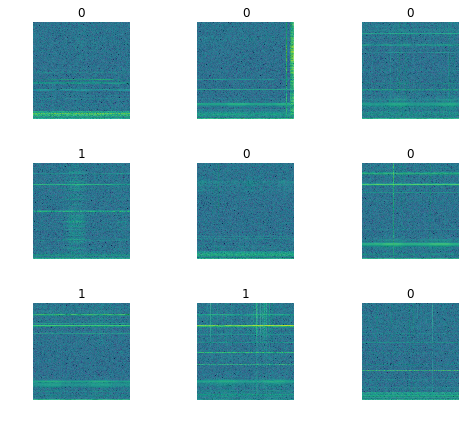

In [38]:
data.show_batch(rows=3, figsize=(7,6))

In [39]:
print(data.classes)
len(data.classes),data.c

[0, 1]


(2, 2)

## Resnet 34

Resnet50 crashes GPUs

In [40]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [41]:
learn.model = torch.nn.DataParallel(learn.model, device_ids=[0,1])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-06


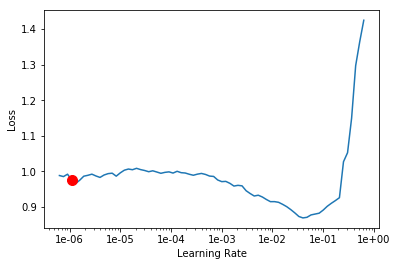

In [42]:
learn.lr_find()
learn.recorder.plot()

In [43]:
learn.fit_one_cycle(cyc_len=5, max_lr=3e-3)

epoch,train_loss,valid_loss,error_rate
1,0.549889,0.463503,0.244336
2,0.438400,0.400974,0.194136
3,0.331633,0.329139,0.153043
4,0.217536,0.213788,0.085962
5,0.155345,0.165581,0.061084


In [44]:
learn.save(f'{MODEL_NAME}_aug_stage-1_rn34_{DATE}')

In [45]:
learn.fit_one_cycle(cyc_len=5, max_lr=slice(1e-4, 1e-3))

epoch,train_loss,valid_loss,error_rate
1,0.135032,0.161677,0.059307
2,0.132759,0.150808,0.053976
3,0.117382,0.157711,0.054420
4,0.096559,0.257163,0.101733
5,0.083487,0.166117,0.060195


In [46]:
learn.save(f'{MODEL_NAME}_aug_stage-1-1_rn34_{DATE}')

## Densenet

Densenet169 too memory intensive for 2x1080ti's

limited to dn121

In [40]:
from torchvision.models import densenet121
#from torchvision.models import densenet169

In [41]:
learn = create_cnn(data, densenet121, metrics=[error_rate])

In [42]:
learn.model = torch.nn.DataParallel(learn.model, device_ids=[0,1])

In [43]:
learn.lr_find()
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: CUDA out of memory. Tried to allocate 351.62 MiB (GPU 0; 10.92 GiB total capacity; 10.07 GiB already allocated; 138.25 MiB free; 83.04 MiB cached)

In [150]:
learn.fit_one_cycle(cyc_len=5, max_lr=slice(1e-3))

epoch,train_loss,valid_loss,error_rate
1,0.404544,0.269203,0.099076
2,0.395487,0.261317,0.096209
3,0.336282,0.259196,0.105448
4,0.358612,0.256720,0.086970
5,0.332084,0.252830,0.079325


In [151]:
learn.save(f'{MODEL_NAME}_aug_stage-1_dn121_{DATE}')

In [152]:
learn.fit_one_cycle(cyc_len=5, max_lr=slice(1e-3))

epoch,train_loss,valid_loss,error_rate
1,0.335946,0.239432,0.072316
2,0.298339,0.248762,0.090156
3,0.321821,0.221366,0.059892
4,0.260374,0.206668,0.062440
5,0.286072,0.204247,0.063396


In [153]:
learn.save(f'{MODEL_NAME}_aug_stage-1-1_dn121_{DATE}')

In [154]:
learn.fit_one_cycle(cyc_len=5, max_lr=slice(1e-3))

epoch,train_loss,valid_loss,error_rate
1,0.303652,0.209009,0.061166
2,0.325268,0.202550,0.060529
3,0.335047,0.235522,0.063077
4,0.266356,0.216865,0.061485
5,0.268174,0.213009,0.065307


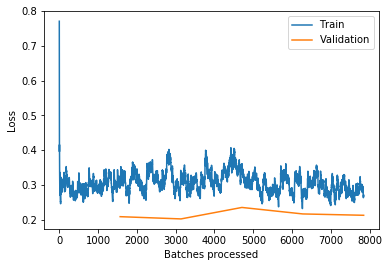

In [156]:
learn.recorder.plot_losses()

In [155]:
learn.load(f'{MODEL_NAME}_aug_stage-1_dn121_{DATE}')

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (12557 items)
[Category 0, Category 0, Category 1, Category 1, Category 0]...
Path: ../input/train_600_ts_aug_viridis-70-20
x: ImageItemList (12557 items)
[Image (3, 600, 600), Image (3, 600, 600), Image (3, 600, 600), Image (3, 600, 600), Image (3, 600, 600)]...
Path: ../input/train_600_ts_aug_viridis-70-20;

Valid: LabelList
y: CategoryList (3139 items)
[Category 0, Category 0, Category 1, Category 1, Category 1]...
Path: ../input/train_600_ts_aug_viridis-70-20
x: ImageItemList (3139 items)
[Image (3, 600, 600), Image (3, 600, 600), Image (3, 600, 600), Image (3, 600, 600), Image (3, 600, 600)]...
Path: ../input/train_600_ts_aug_viridis-70-20;

Test: None, model=DataParallel(
  (module): Sequential(
    (0): Sequential(
      (0): Sequential(
        (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_sta

### unfreeze

In [157]:
learn.unfreeze()


In [158]:
learn.lr_find()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


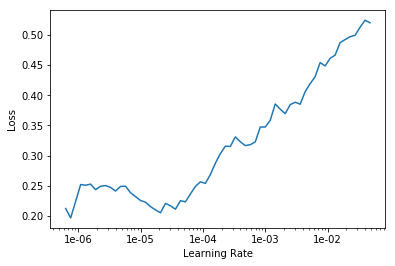

In [159]:
learn.recorder.plot()

In [160]:
learn.fit_one_cycle(3, max_lr=slice(1e-5))

epoch,train_loss,valid_loss,error_rate
1,0.332745,0.215007,0.071679
2,0.366171,0.233327,0.077413
3,0.310426,0.229273,0.084422


In [161]:
learn.save(f'{MODEL_NAME}_aug_stage-2_dn121_{DATE}')

In [162]:
interp = ClassificationInterpretation.from_learner(learn)

In [163]:
interp.most_confused(min_val=2)

[(0, 1, 196), (1, 0, 69)]

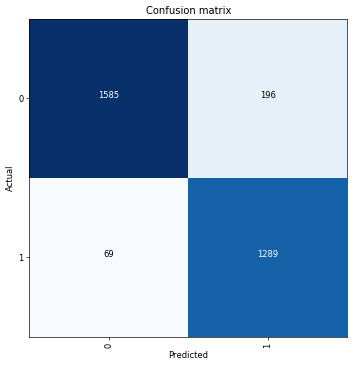

In [167]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

### Predict

In [168]:
test_images = glob.glob(str(test_path)+"/*.jpg")

In [169]:
learn.load(f'{MODEL_NAME}_aug_stage-2_dn121_{DATE}')

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (12557 items)
[Category 0, Category 0, Category 1, Category 1, Category 0]...
Path: ../input/train_600_ts_aug_viridis-70-20
x: ImageItemList (12557 items)
[Image (3, 600, 600), Image (3, 600, 600), Image (3, 600, 600), Image (3, 600, 600), Image (3, 600, 600)]...
Path: ../input/train_600_ts_aug_viridis-70-20;

Valid: LabelList
y: CategoryList (3139 items)
[Category 0, Category 0, Category 1, Category 1, Category 1]...
Path: ../input/train_600_ts_aug_viridis-70-20
x: ImageItemList (3139 items)
[Image (3, 600, 600), Image (3, 600, 600), Image (3, 600, 600), Image (3, 600, 600), Image (3, 600, 600)]...
Path: ../input/train_600_ts_aug_viridis-70-20;

Test: None, model=DataParallel(
  (module): Sequential(
    (0): Sequential(
      (0): Sequential(
        (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [170]:
d={}
for i,fname in enumerate(test_images):
    im_name=fname.split('/')[3]
    signal_id = im_name[:im_name.index(".")]
    img = open_image(test_images[i])
    cat, val, probs=learn.predict(img)
    d[signal_id]=cat.__str__()
    #print(f'signal_id: {signal_id}, cat: {cat.__str__()}, val: {val}')

In [171]:
df_sub_dn121_u=pd.DataFrame.from_dict(d, orient='index')

In [172]:
df_sub_dn121_u=df_sub_dn121_u.reset_index()


In [173]:
df_sub_dn121_u.rename(columns={'index': 'signal_id', 0: 'target'}, inplace=True)
df_sub_dn121_u.head()

,signal_id,target
0,8847,0
1,25536,1
2,24202,0
3,11043,0
4,25522,0


In [174]:
df_sub_dn121_u.to_csv(path/f'submissions/submission_aug_densenet121_unfeeze-2_{DATE}_{UID}.csv', index=False)

In [ ]:
#submission 9 0.363
#worst submission yet !!!
